In [51]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df0 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/GPT_5_1/Matrix_Scores_GPT5_1_Administrative.csv").sort_values("ID")
df1 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/llama-3.3-70b-instruct/Matrix_Scores_llama-3.3-70b-instruct_Administrative.csv").sort_values("ID")
df2 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Administrative.csv").sort_values("ID")

lower_better = ["TTR", "LD", "WR", "MDD", "SI", "Cross", "WSF", "LIX", "Fog"]
higher_better = ["FRE","WSF"]

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparison(df, metric_type="Holistic", text="Administrative"):

    # Convert to long format
    df_long = df.melt(
        id_vars=["Metric", "Posthoc_result"],
        value_vars=["GPT5.1_mean", "LLaMA_mean", "Qwen_mean"],
        var_name="Model",
        value_name="Score"
    )

    df_long["Model"] = df_long["Model"].str.replace("_mean", "")

    # ---- Plot ----
    plt.figure(figsize=(max(12, len(df)*0.8), 6))

    ax = sns.barplot(
        data=df_long,
        x="Metric",
        y="Score",
        hue="Model"
    )

    # Get global max for spacing
    global_max = df_long["Score"].max()

    # ---- Add value labels ----
    for patch in ax.patches:
        height = patch.get_height()
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + global_max * 0.02,  # dynamic vertical offset
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    # ---- Add significance stars ----
    # ---- Add significance stars ----
    for i, row in df.iterrows():
        if str(row["Posthoc_result"]).lower() == "significant":
            max_score = max(
                row["GPT5.1_mean"],
                row["LLaMA_mean"],
                row["Qwen_mean"]
            )
            ax.text(
                i,
                max_score + global_max * 0.08,
                "*",
                ha='center',
                va='bottom',
                fontsize=18
            )



    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Model")

    # Add explanation for star
    plt.figtext(
        0.99, 0.01,
        "* Significant (Bonferroni-corrected post-hoc)",
        horizontalalignment='right',
        fontsize=10
    )

    plt.tight_layout()
    plt.show()


In [94]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations
from statsmodels.stats.multitest import multipletests


# ----- Define metric direction clearly ----- #
lower_better = ["TTR","MDD", "LIX", "Fog", "Cross", "WR","LD","SI"]
higher_better = ["WSF", "FRE"]


# ----- Kendall's W ----- #
def kendalls_w(x, y, z):
    n = len(x)
    k = 3
    ranks = np.vstack([
        stats.rankdata(x),
        stats.rankdata(y),
        stats.rankdata(z)
    ])
    R = np.sum(ranks, axis=0)
    S = np.sum((R - np.mean(R))**2)
    denom = (k**2 * (n**3 - n))
    return np.nan if denom == 0 else 12 * S / denom


# ----- Main function ----- #
def compare_models(df0, df1, df2, metric_type="Holistic"):
    # Keep first 20 rows
    df0 = df0.head(20).reset_index(drop=True)
    df1 = df1.head(20).reset_index(drop=True)
    df2 = df2.head(20).reset_index(drop=True)

    # Ensure identical indexing
    assert len(df0) == len(df1) == len(df2)


    metrics = [c.replace(f"_{metric_type}", "")
               for c in df0.columns if c.endswith(f"_{metric_type}")]

    if not metrics:
        raise ValueError(f"No *_{metric_type} columns found.")

    wins_all = {"GPT5.1": 0, "LLaMA-3.3-70B": 0, "Qwen3-235B": 0}
    wins_significant = {"GPT5.1": 0, "LLaMA-3.3-70B": 0, "Qwen3-235B": 0}

    rows = []

    for metric in metrics:

        col = f"{metric}_{metric_type}"

        tmp = pd.DataFrame({
            'GPT5.1': df0[col].astype(float),
            'LLaMA-3.3-70B': df1[col].astype(float),
            'Qwen3-235B': df2[col].astype(float)
        })


        x = tmp['GPT5.1'].values
        y = tmp['LLaMA-3.3-70B'].values
        z = tmp['Qwen3-235B'].values


        # ---------- Friedman Test ----------
        stat, p_value = friedmanchisquare(x, y, z)

        # ---------- Kendall's W ----------
        W = kendalls_w(x, y, z)

        means = tmp.mean()

        # ---------- Descriptive winner ----------
        if metric in lower_better:
            best_model = means.idxmin()
        elif metric in higher_better:
            best_model = means.idxmax()
        else:
            best_model = "Unknown"

        if best_model in wins_all:
            wins_all[best_model] += 1

        # ---------- Post-hoc testing ----------
        posthoc_results = {}
        significant_posthoc = False

        if p_value < 0.05:

            pairs = list(combinations(tmp.columns, 2))
            raw_pvals = []
            pair_names = []

            for a, b in pairs:
                stat_w, p_w = wilcoxon(tmp[a], tmp[b])
                raw_pvals.append(p_w)
                pair_names.append(f"{a} vs {b}")

            # Bonferroni correction
            adjusted_pvals = multipletests(raw_pvals, method='bonferroni')[1]

            if any(p < 0.05 for p in adjusted_pvals):
              significant_posthoc = True


        # ---------- Count significant wins ----------
        if significant_posthoc and best_model in wins_significant:
            wins_significant[best_model] += 1

        rows.append({
            "Metric": metric,
            "n": len(tmp),
            "Friedman_p": round(p_value, 6),
            "Kendalls_W": round(W, 4),
            "GPT5.1_mean": round(means["GPT5.1"], 3),
            "LLaMA_mean": round(means["LLaMA-3.3-70B"], 3),
            "Qwen_mean": round(means["Qwen3-235B"], 3),
            "Winner": best_model,
            "Posthoc_result": "Significant" if significant_posthoc else "Not Significant"

        })

    result_df = pd.DataFrame(rows)

    print("\n===== Total Wins (Descriptive) =====")
    for model, count in wins_all.items():
        print(model, ":", count)

    print("\n===== Significant Wins (Post-hoc Confirmed) =====")
    for model, count in wins_significant.items():
        print(model, ":", count)

    return result_df, wins_all, wins_significant


In [95]:
print("=======================ADMINISTRATIVE=======================\n\n")

print("--------------Holistic------------------")
holistic_df, holistic_wins_all, holistic_wins_sig = compare_models(df0, df1, df2, metric_type="Holistic")
print(holistic_df)

print("\n\n--------------Linguistic------------------")
# Linguistic metrics
linguistic_df, ling_wins_all, ling_wins_sig = compare_models(df0, df1, df2, metric_type="Linguistic")
print(linguistic_df)


=======================ADMINISTRATIVE=======================


--------------Holistic------------------

===== Total Wins (Descriptive) =====
GPT5.1 : 1
LLaMA-3.3-70B : 4
Qwen3-235B : 5

===== Significant Wins (Post-hoc Confirmed) =====
GPT5.1 : 1
LLaMA-3.3-70B : 4
Qwen3-235B : 3
  Metric   n  Friedman_p  Kendalls_W  GPT5.1_mean  LLaMA_mean  Qwen_mean  \
0    TTR  20    0.000002      0.2945        0.433       0.503      0.317   
1     LD  20    0.000001      0.3338        0.571       0.511      0.483   
2     WR  20    0.000000      0.4957        0.485       0.449      0.617   
3    MDD  20    0.001294      0.4379        2.562       2.205      2.436   
4     SI  20    0.002358      0.4828        0.246       0.295      0.328   
5  Cross  20    0.000003      0.5731       14.300       2.350     16.850   
6    WSF  20    0.047359      0.5445        4.119       4.440      4.007   
7    LIX  20    0.522046      0.4784       40.939      41.131     40.457   
8    FRE  20    0.286505      0.556

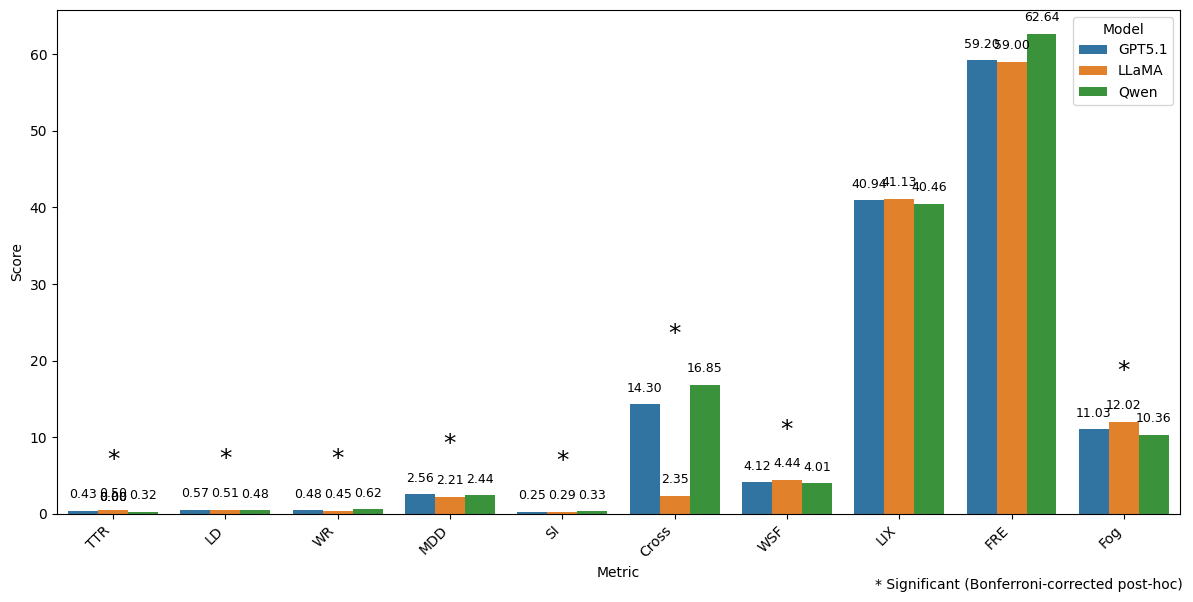

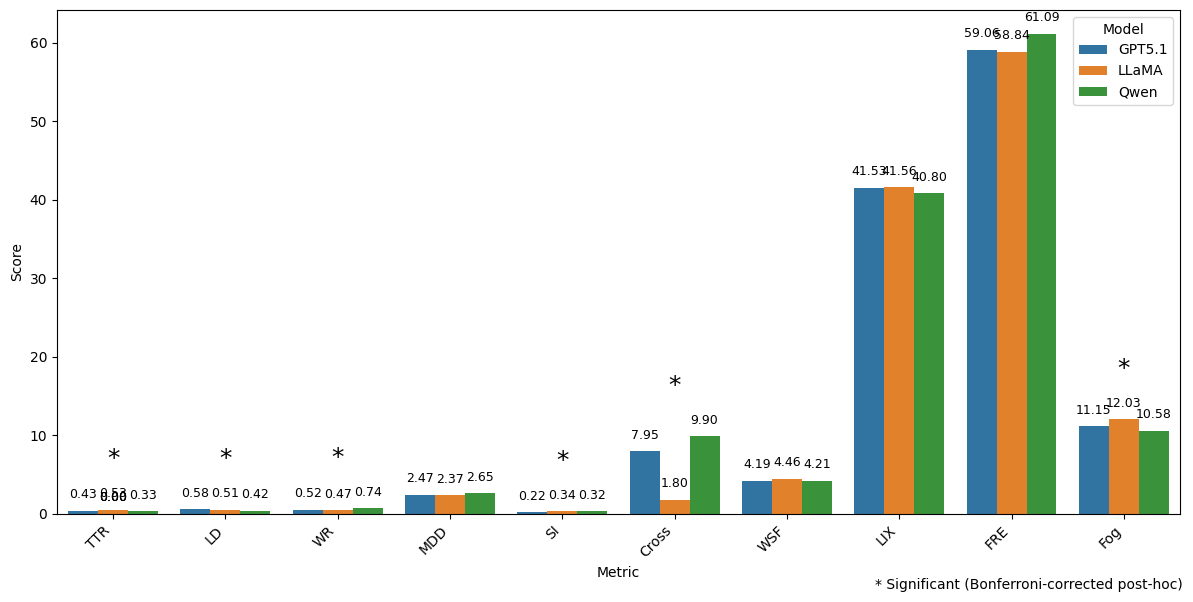

In [96]:

plot_model_comparison(holistic_df, metric_type="Holistic", text = "Administrative")
plot_model_comparison(linguistic_df, metric_type="Linguistic", text = "Administrative")

# Ausgangstexte

In [97]:

df0 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/GPT_5_1/Matrix_Scores_GPT5_1_ausgangstexte.csv").sort_values("ID")
df1 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/llama-3.3-70b-instruct/Matrix_Scores_llama-3.3-70b-instruct_Ausgangstexte.csv").sort_values("ID")
df2 = pd.read_csv("https://raw.githubusercontent.com/happy522/ChatGPT-as-a-CAT-tool-in-Easy-language-translation_Implemenatation/refs/heads/main/qwen3-235b-a22b/Matrix_Scores_qwen3-235b-a22b_Ausgangstexte.csv").sort_values("ID")

print("=======================AUSGANGETEXTE=======================\n\n")

print("--------------Holistic------------------\n")
holistic_df, holistic_wins_all, holistic_wins_sig = compare_models(df0, df1, df2, metric_type="Holistic")
print(holistic_df)

print("\n\n--------------Linguistic------------------")
# Linguistic metrics
linguistic_df, ling_wins_all, ling_wins_sig = compare_models(df0, df1, df2, metric_type="Linguistic")
print(linguistic_df)


=======================AUSGANGETEXTE=======================


--------------Holistic------------------


===== Total Wins (Descriptive) =====
GPT5.1 : 1
LLaMA-3.3-70B : 4
Qwen3-235B : 5

===== Significant Wins (Post-hoc Confirmed) =====
GPT5.1 : 1
LLaMA-3.3-70B : 4
Qwen3-235B : 3
  Metric   n  Friedman_p  Kendalls_W  GPT5.1_mean  LLaMA_mean  Qwen_mean  \
0    TTR  20    0.000002      0.2945        0.433       0.503      0.317   
1     LD  20    0.000001      0.3338        0.571       0.511      0.483   
2     WR  20    0.000000      0.4957        0.485       0.449      0.617   
3    MDD  20    0.001294      0.4379        2.562       2.205      2.436   
4     SI  20    0.002358      0.4828        0.246       0.295      0.328   
5  Cross  20    0.000003      0.5731       14.300       2.350     16.850   
6    WSF  20    0.047359      0.5445        4.119       4.440      4.007   
7    LIX  20    0.522046      0.4784       40.939      41.131     40.457   
8    FRE  20    0.286505      0.556

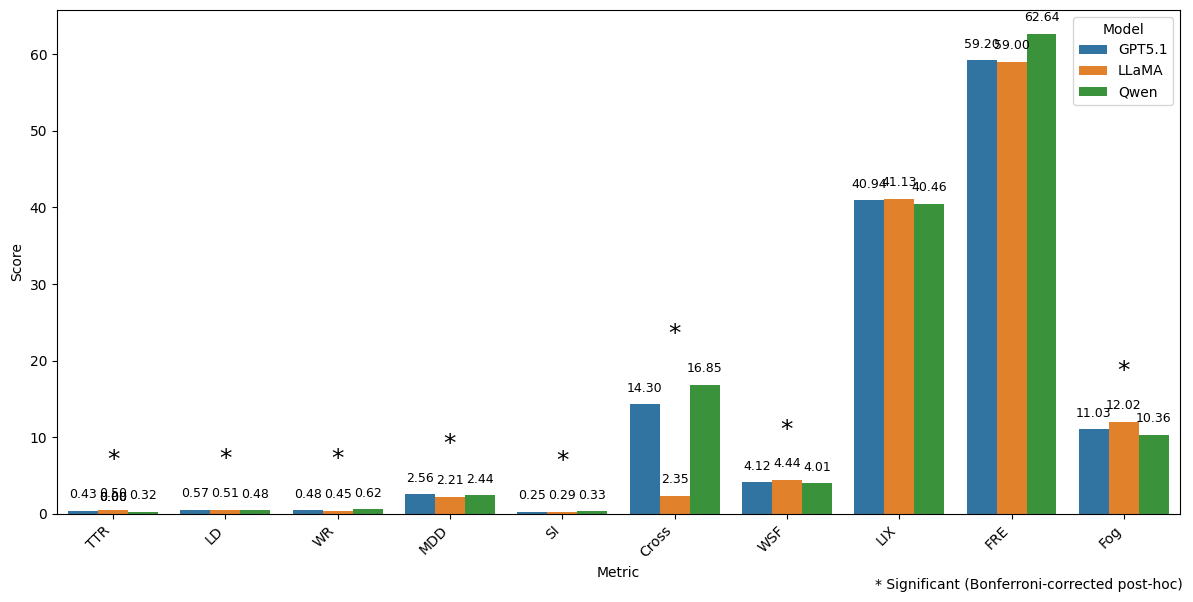

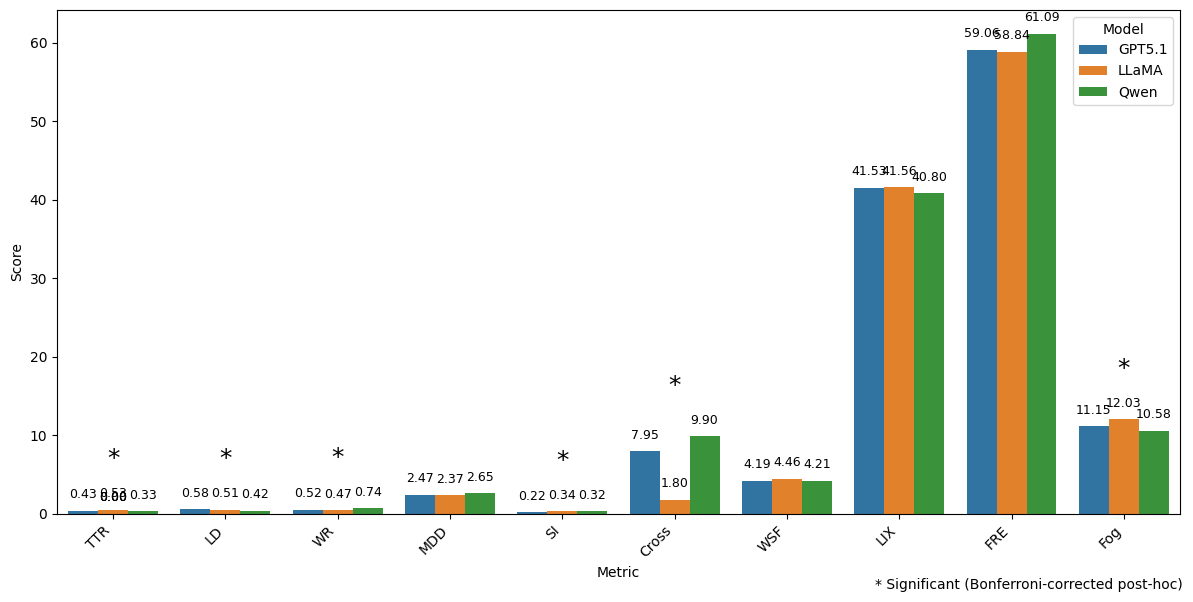

In [98]:
plot_model_comparison(holistic_df, metric_type="Holistic", text = "Medical")

plot_model_comparison(linguistic_df, metric_type="Linguistic", text = "Medical")